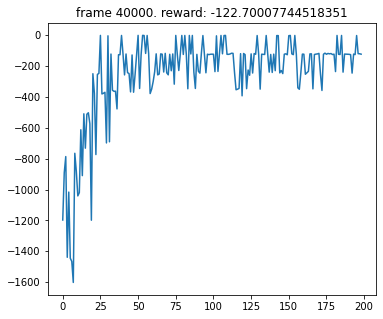

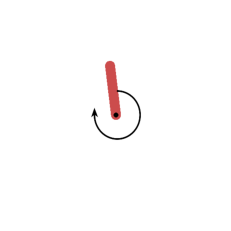

In [1]:
"""Sac implementation based on https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
"""
%matplotlib inline

import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib
from matplotlib import animation
from IPython.display import display
# import tkinter

# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

# Check if GPU is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Training parameters
value_lr = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4
replay_buffer_size = 1000000
max_frames = 40000
max_steps = 500
frame_idx = 0
batch_size = 128

# Network parameters
hidden_dim = 256
value_criterion = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()


class ReplayBuffer:
    """Replay buffer"""

    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(
            np.stack, zip(*batch)
        )  # retrieve s,a,r,s',d out of batch
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


class NormalizedActions(gym.ActionWrapper):
    """Normalize actions"""

    # def __init__(self, env):
    #     super().__init__(env)

    def action(self, action):

        low = self.action_space.low
        high = self.action_space.high

        # Bring normalised data back to original form
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        # Perform min-max scaling around 0 (https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range/281164
        action = 2 * (action - low) / (high - low) - 1  # (1--1)*(a-min)/(max-min) - 1
        action = np.clip(action, low, high)

        return action


def plot(frame_idx, rewards):
    """ Plot function inside jupyter notebook"""
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    # plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(anim)


class ValueNetwork(nn.Module):
    """Value network (Value function)"""

    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        # Initiate weights and biases
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):

        # Forward pass
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class SoftQNetwork(nn.Module):
    """Soft critic network (Q network)"""

    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

        # Initiate weights
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):

        # Forward pass
        x = torch.cat([state, action], 1)
        # Concatenates tensors Q value over the columns
        # [[state1,action1],[state2,action2]]
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class PolicyNetwork(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_actions,
        hidden_size,
        init_w=3e-3,
        log_std_min=-20,
        log_std_max=2,
    ):
        super(PolicyNetwork, self).__init__()

        # Clamp log std to be within bounds
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # Linear layers
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # Mean layer output neuron
        self.mean_linear = nn.Linear(hidden_size, num_actions)

        # Log std output neuron
        self.log_std_linear = nn.Linear(hidden_size, num_actions)

        # Initiate weights and biases
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))

        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mean, log_std

    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()

        # Sample noise
        normal = Normal(0, 1)
        z = normal.sample()

        # Calculate action
        action = torch.tanh(
            mean + std * z.to(device)
        )  # Squashed gaussian distribution derived from normal distribution.
        log_prob = Normal(mean, std).log_prob(mean + std * z.to(device)) - torch.log(
            1 - action.pow(2) + epsilon
        )  # Haarnoja 2018 eq 21 - Simplified since diagonal matrix
        return action, log_prob, z, mean, log_std

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(0, 1)
        z = normal.sample().to(device)
        action = torch.tanh(mean + std * z)  # Approximate log likelihood

        action = action.cpu()
        return action[0]


def update(
    batch_size, gamma=0.99, soft_tau=1e-2,
):
    """Update networks"""

    # Sample experience batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Unpack experience and create tensors
    state = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action = torch.FloatTensor(action).to(device)
    reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Retrieve predicted values from the networks
    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    # Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = (
        reward + (1 - done) * gamma * target_value
    )  # Make sure that reward is reward when terminal state

    # Calculate soft critic loss functions
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())
    print("Q Loss")
    print(q_value_loss1)

    # Back soft critic loss (Stochastic gradient descent)
    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()

    # Training Value Function
    predicted_new_q_value = torch.min(
        soft_q_net1(state, new_action), soft_q_net2(state, new_action)
    )  # Min-clipping to prevent overestimation bias

    # Calculate value loss function
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())
    print("V Loss")
    print(value_loss)

    # Back propograte loss
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()  # Training Policy Function

    # Calculate policy loss
    policy_loss = (log_prob - predicted_new_q_value).mean()

    # Back propagate policy loss
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    # Copy over value network parameters to target network parameters
    # Uses Polyak averaging
    for target_param, param in zip(
        target_value_net.parameters(), value_net.parameters()
    ):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )  # Exponential decay averaging


if __name__ == "__main__":

    # Create Gym environment
    env = NormalizedActions(gym.make("Pendulum-v0"))

    # Set action and observation shape
    action_dim = env.action_space.shape[0]
    state_dim = env.observation_space.shape[0]

    # Create value and target networks (Hard critic)
    value_net = ValueNetwork(state_dim, hidden_dim).to(device)
    target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

    # Create twin soft critic networks (Min-clipping trick)
    soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
    soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)

    # Create policy network
    policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

    # Make sure the target network has the same parameters as the value network
    for target_param, param in zip(
        target_value_net.parameters(), value_net.parameters()
    ):
        target_param.data.copy_(param.data)

    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)
    soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
    soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    replay_buffer = ReplayBuffer(replay_buffer_size)

    # Create reward storage bucket
    rewards = []

    # Run training loop
    while frame_idx < max_frames:  # stop if global max frames are reached

        # Reset environment and episode reward
        state = env.reset()
        episode_reward = 0

        # Episode loop (Perform steps)
        for step in range(max_steps):

            # Sample action from the policy network
            if frame_idx > 1000:
                action = policy_net.get_action(state).detach()
                next_state, reward, done, _ = env.step(action.numpy())
            else:  # First frames take random sample from the action space
                action = env.action_space.sample()
                next_state, reward, done, _ = env.step(action)

            # Add experiences to replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # Increment state episode reward and frame id
            state = next_state
            episode_reward += reward
            frame_idx += 1

            # Update batch size
            if len(replay_buffer) > batch_size:
                update(batch_size)

            # Write episode reward to plot every 1000 steps
            if frame_idx % 1000 == 0:
                plot(frame_idx, rewards)

            # Break out of the loop when the episode is finished
            if done:
                break

        # Save episode reward
        rewards.append(episode_reward)

    # Run inference
    env = gym.make("Pendulum-v0")
    state = env.reset()
    cum_reward = 0
    frames = []
    for t in range(50000):
        # Render into buffer.
        frames.append(env.render(mode="rgb_array"))
        action = policy_net.get_action(state)
        state, reward, done, info = env.step(action.detach())
        if done:
            break
    env.close()
    display_frames_as_gif(frames)
